<a href="https://colab.research.google.com/github/atharvshimpi1/DeepMRI/blob/master/XceptionCNN%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import os
import shutil
import zipfile

# GitHub repository URL
repo_url = 'https://github.com/atharvshimpi1/MRI_Brain_Tumor_dataset.git'
repo_dir = '/content/MRI_images_Dataset'

# Clear the existing directory if it exists
if os.path.exists(repo_dir):
    shutil.rmtree(repo_dir)

# Clone the repository
print(f'Cloning repository from {repo_url}...')
os.system(f'git clone {repo_url} {repo_dir}')
print('Repository cloned.')

# Navigate to the dataset directory
dataset_dir = os.path.join(repo_dir, 'datasets')
os.makedirs(dataset_dir, exist_ok=True)

# Unzip any zip files found in the dataset directory
for item in os.listdir(dataset_dir):
    if item.endswith('.zip'):
        file_path = os.path.join(dataset_dir, item)
        print(f'Extracting {file_path}...')
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(dataset_dir)
        os.remove(file_path)  # Optionally remove the zip file after extraction
        print(f'{item} extracted.')

# Verify the files in the dataset directory
print('Data source import complete.')
print("Files in dataset directory:")
print(os.listdir(dataset_dir))


Cloning repository from https://github.com/atharvshimpi1/MRI_Brain_Tumor_dataset.git...
Repository cloned.
Data source import complete.
Files in dataset directory:
[]


   <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#003166;font-family:newtimeroman;font-size:150%;text-align:center;border-radius:50px 10px;">TABLE OF CONTENTS</p>   
    
* [1. Import Libraries](#1)
    
* [2. Data Preparation](#2)
    
* [3. Transfer Learning](#3)   
      
* [4. Xception](#6)
    
* [5. Export Model](#7)

<a id="2"></a>
# <p style="background-color:#003166;font-family:newtimeroman;font-size:150%;text-align:center;border-radius:50px 10px;">Import Libraries</p>

In [19]:
!pip install mplcyberpunk

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D,GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from tqdm import tqdm

from warnings import filterwarnings
for dirname, _, filenames in os.walk('/content/MRI_images_Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

<a id="2"></a>
# <p style="background-color:#003166;font-family:newtimeroman;font-size:150%;text-align:center;border-radius:50px 10px;">Data Preperation</p>

In [ ]:
X_train = []
y_train = []
labels = ['glioma','notumor','meningioma','pituitary']


image_size = 150
for i in labels:
    folderPath = os.path.join('../content/MRI_images_Dataset/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('../content/MRI_images_Dataset/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 300/300 [00:00<00:00, 789.38it/s]


## Data visualization

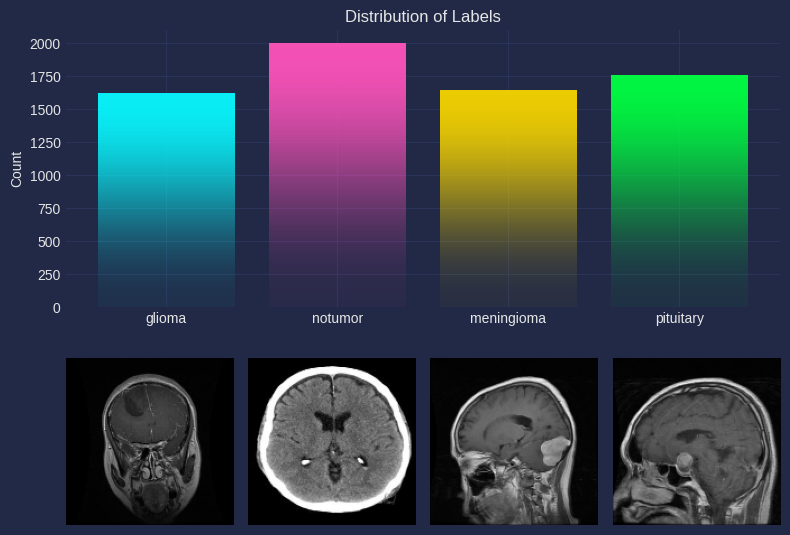

In [ ]:
# Calculate the bar plot for each label
label_counts = {label: np.sum(y_train == label) for label in labels}

# Plot the bar plot and sample images in one chart
plt.figure(figsize=(8, 6))

colors = ["C0", "C1", "C2", "C3"]

# Plot the histogram
plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)
mplcyberpunk.add_bar_gradient(bars=bars)
# plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Plot sample images from each label
k = 0
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            plt.subplot(2, 4, k + 5)
            plt.imshow(X_train[j])
            plt.axis('off')
            k += 1
            break
        j += 1

plt.tight_layout()
plt.show()


### Dataset Split: Train and Test

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

### One-Hot Encoding Labels

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

<a id="3"></a>
# <p style="background-color:#003166;font-family:newtimeroman;font-size:150%;text-align:center;border-radius:50px 10px;">Transfer Learning</p>

Transfer learning uses knowledge learned from training on one task to improve learning on another, which is especially beneficial when data is limited. The model can learn more quickly and avoid overfitting by using learned features from a related task. It works by starting with a pre-trained model's base layers, identifying transfer layers capturing relevant information, and fine-tuning these layers with new task data to adapt the model efficiently. This method is particularly useful in deep learning for tasks involving image recognition and classification.

**Fundamental Components and Techniques in Neural Network Training**

1. Dense: A fully connected layer that learns complicated patterns in data by connecting all neurons in the previous and subsequent layers.

2. GlobalAveragePooling2D: A pooling layer that determines the average value of each feature map across spatial dimensions, lowering spatial dimensions and keeping crucial information.

3. Dropout: a regularization technique that randomly sets a fraction of input units to zero during training, preventing overfitting and requiring the model to learn resilient features.

4. BatchNormalization: This technique normalizes each layer's activations to stabilize training and reduce internal covariate shift, resulting in faster convergence and improved generalization.

5. Callbacks: Callbacks are TensorFlow/Keras functions that can do specific actions during training, such as storing the model, adjusting learning rates, or halting training based on conditions.

6. Early Stopping: A callback technique that halts training when a monitored metric stops improving, preventing overfitting and conserving computational resources.

Xception, a revolutionary CNN architecture, incorporates depthwise separable convolutions, which reduces parameters and computational cost while maintaining efficacy. It uses separable convolutional blocks, an entry-exit flow structure, and skip connections similar to ResNet to provide efficient training and hierarchical feature learning. Key approaches include global depthwise convolutions for context understanding, data augmentation, batch normalization for stability, and transfer learning potential from ImageNet. With 71 layers, pretrained Xception performs at ImageNet classification, demonstrating its efficiency and adaptability in deep learning tasks.

In [ ]:
# Load the Xception model pretrained on ImageNet without the top layers
xception = tf.keras.applications.Xception(weights='imagenet', include_top=False,
                                          input_shape=(image_size, image_size, 3))

# Build the custom model on top of the Xception base
model = xception.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1536,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=xception.input, outputs = model)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
model.summary()

In [ ]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model
checkpoint = ModelCheckpoint("efficientnetB0.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,
                              min_delta=0.0001, verbose=1)

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()

## <p style="background-color:#003166;font-family:newtimeroman;font-size:150%;text-align:center;border-radius:50px 10px;">Evaluation</p>

22/22 [==============================] - 58s 3s/step


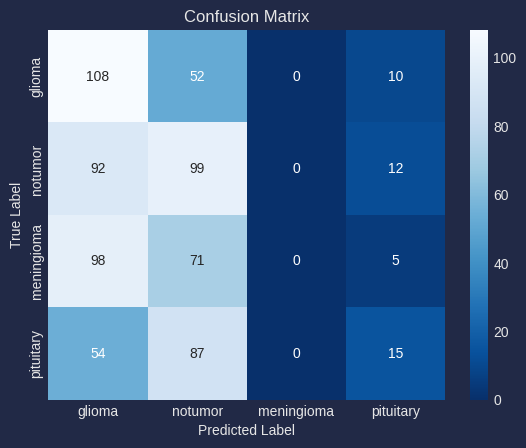

In [ ]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
print(classification_report(y_true_test,y_pred_test))

## <p style="background-color:#003166;font-family:newtimeroman;font-size:150%;text-align:center;border-radius:50px 10px;">Prediction</p>

In [ ]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()


In [7]:
from keras.models import load_model
import tensorflow as tf



converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

print("model converted")

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

model converted


1/1 [==============================] - 1s 740ms/step
Predicted label: glioma 
Actual label: glioma 
Confidence: 100.00%



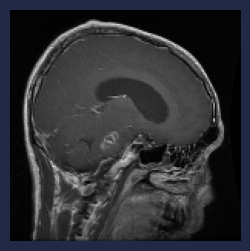

In [ ]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()

# <p><center style="color:#003166;font-family:newtimeroman;;">Thank You!</center></p>